In [1]:
import jax
import jax.numpy as jnp

from specq_jax.data import load_model
from specq_jax.core import (
    X,
    gate_loss,
    calculate_expvals,
    plot_expvals,
    get_simulator,
    rotating_transmon_hamiltonian,
    optimize,
    gate_fidelity,
    evalulate_model_to_pauli
)
from specq_jax.model import BasicBlackBox
from specq_jax.pulse import MultiDragPulse
from specq_dev.specq.jax import JaxBasedPulseSequence
import specq_dev.specq.shared as specq

In [2]:
PATH = "models/0020"
DATA_PATH = "../../specq-experiment/datasets/0020"
model_state, restored_history, data_config = load_model(PATH)

pulse_sequence = JaxBasedPulseSequence.from_dict(
    data_config.pulse_sequence,
    [MultiDragPulse] * len(data_config.pulse_sequence["pulses"]),
)

exp_config = specq.ExperimentConfigV3.from_file(DATA_PATH)

t_eval = jnp.linspace(
    0,
    pulse_sequence.pulse_length_dt * exp_config.device_cycle_time_ns,
    pulse_sequence.pulse_length_dt,
)

simulator = get_simulator(
    qubit_info=exp_config.qubits[0],
    t_eval=t_eval,
    hamiltonian=rotating_transmon_hamiltonian,
)

gate_optim_key = jax.random.PRNGKey(0)
model = BasicBlackBox(**model_state.model_config)

/Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.12/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable

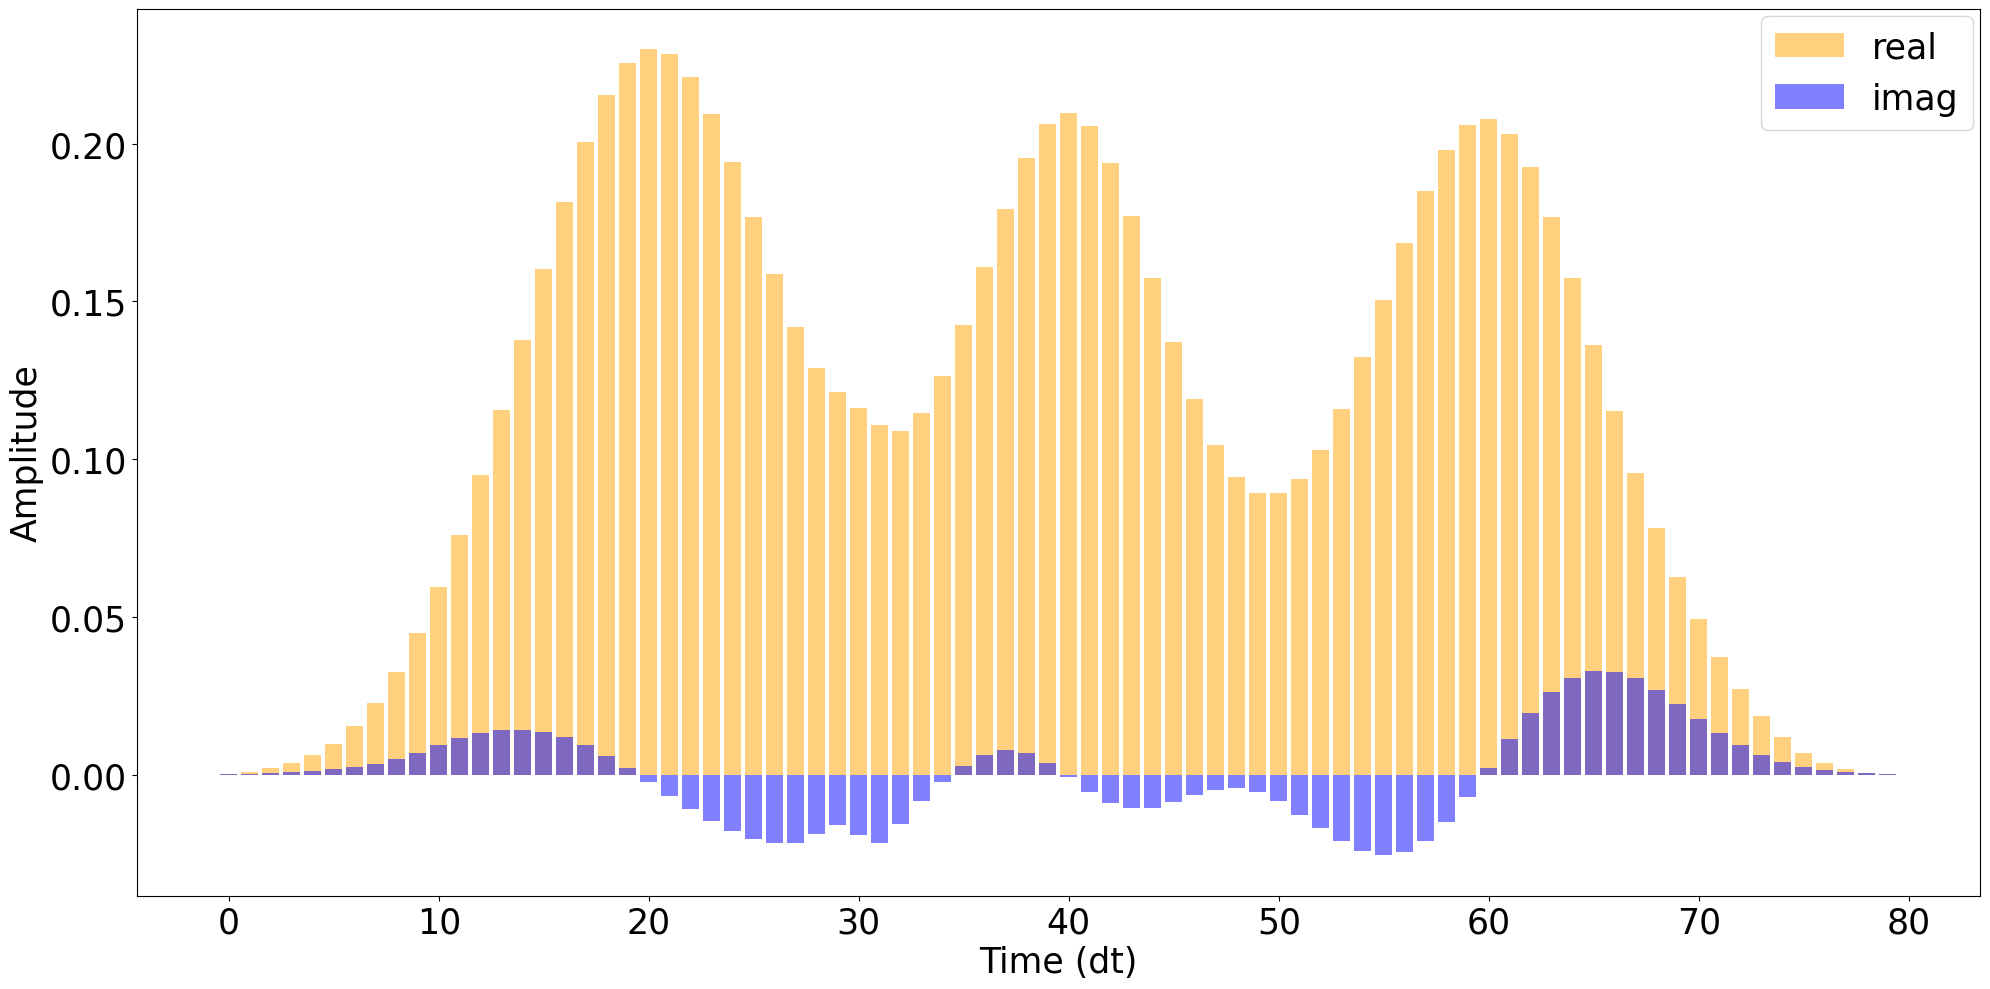

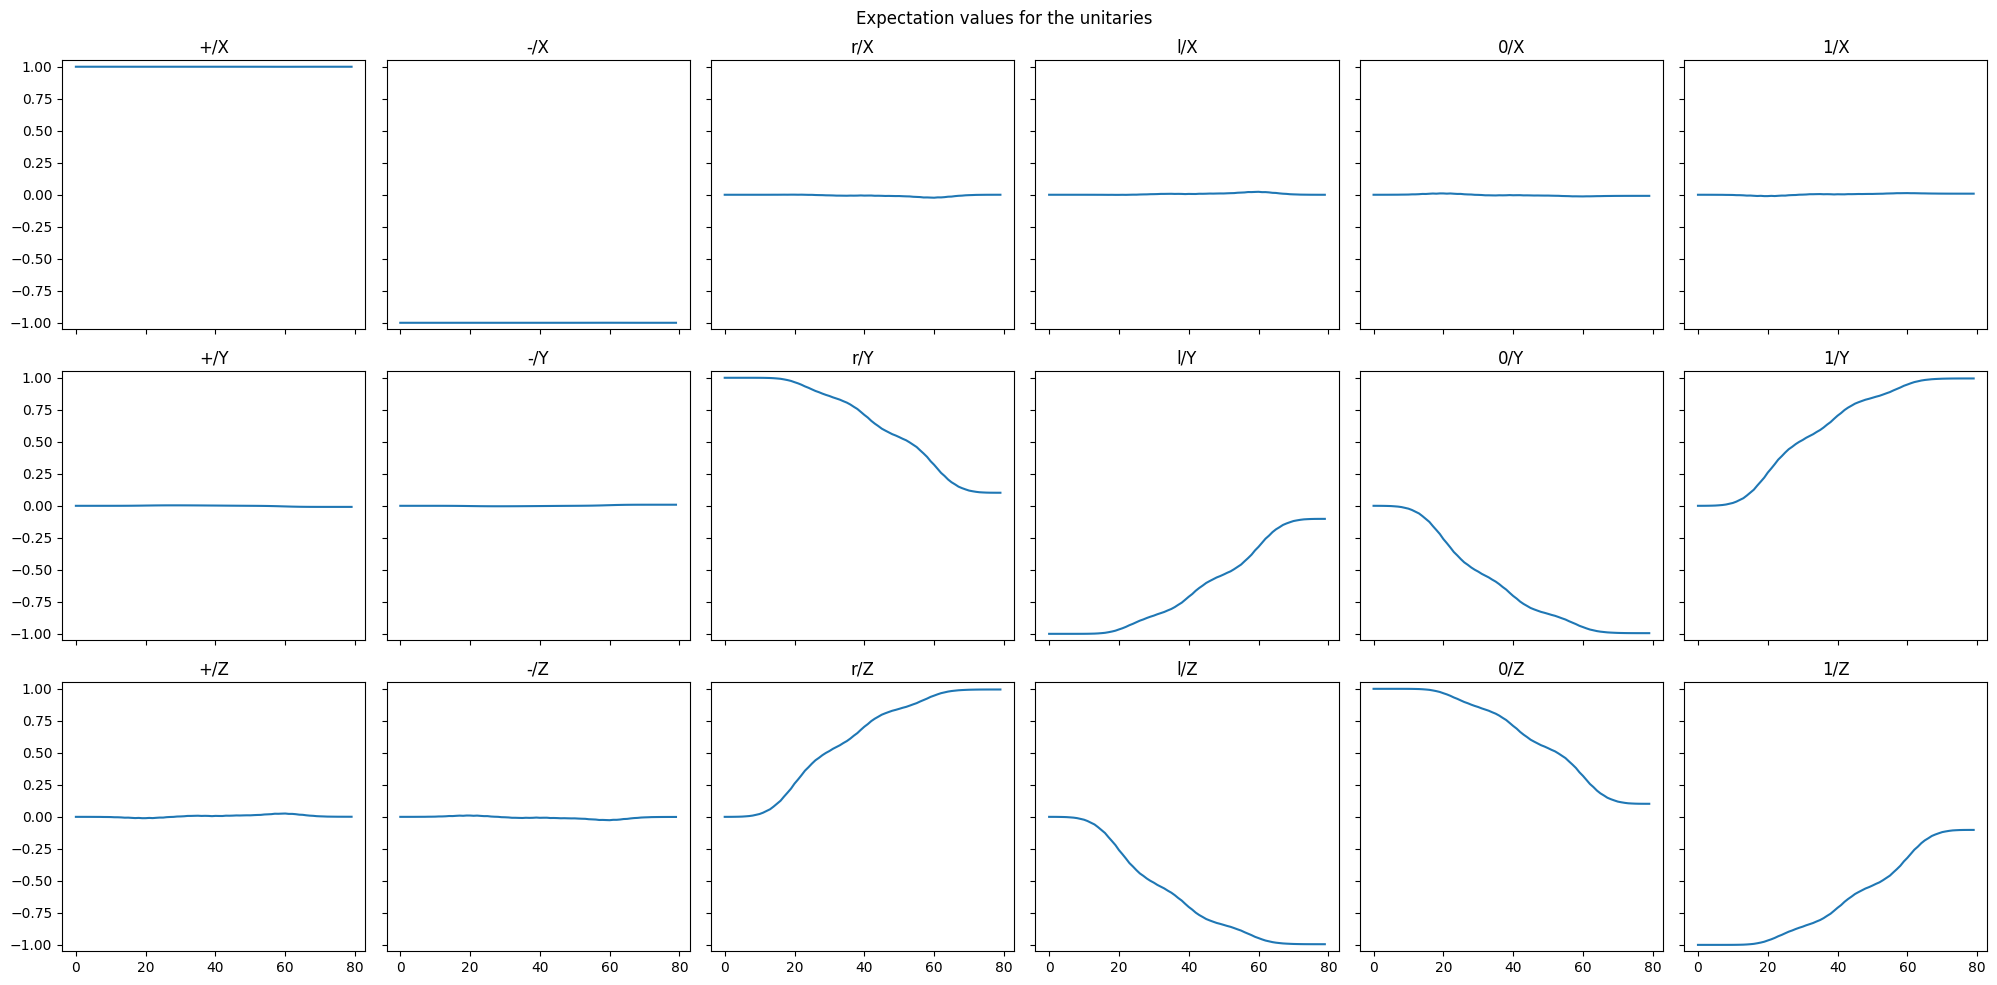

In [3]:
target_unitary = jax.scipy.linalg.sqrtm(X)
fun = lambda x: gate_loss(
    x,
    model,
    model_state.model_params,
    simulator,
    pulse_sequence,
    target_unitary,
)

lower, upper = pulse_sequence.get_bounds()
lower = pulse_sequence.list_of_params_to_array(lower)
upper = pulse_sequence.list_of_params_to_array(upper)

pulse_params = pulse_sequence.sample_params(gate_optim_key)
x0 = pulse_sequence.list_of_params_to_array(pulse_params)

opt_params, state = optimize(x0, lower, upper, fun)

# Plot the optmized result
opt_pulse_params = pulse_sequence.array_to_list_of_params(opt_params)
pulse_sequence.draw(opt_pulse_params)

# Calculate the expectation values
waveforms = pulse_sequence.get_waveform(opt_pulse_params)
unitaries_opt = simulator(waveforms)

expvals = calculate_expvals(unitaries_opt)
plot_expvals(expvals)

In [4]:
evalulate_model_to_pauli(model, model_state.model_params, jnp.expand_dims(opt_params, 0))

{'X': Array([0.9980513], dtype=float32),
 'Y': Array([0.9885392], dtype=float32),
 'Z': Array([0.9996824], dtype=float32)}

In [6]:
gate_fidelity(unitaries_opt[-1], target_unitary)

Array(0.9973715, dtype=float32)